In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [92]:
column_names = ["identification", "ground_communication_type", "ground_communication_number", "day_month_year", 
                "weekday", "time", "accident_type", "type_of_collision_of_vehicles", "type_of_obstacle", 
                "life_consequences", "culprits_of_accident", "alcohol_in_culprit", "main_cause_of_accident", 
                "number_of_persons_died", "number_of_seriously_injured", "number_of_lightly_injured", 
                "total_material_damage", "type_of_road_surface", "condition_of_road_surface", 
                "condition_of_communication", "wind_condition", "visibility", "p20", "p21", "p22", "p23", "p24", 
                "p27", "p28", "p34", "p35", "p39", "p44", "p45a", "p47", "p48a", "p49", "p50a", "p50b", "p51", 
                "p52", "p53", "p55a", "p57", "p58", "a", "b", "d", "e", "f", "g", "h", "i", "j", "k", "l", "n", 
                "o", "p", "q", "r", "s", "t", "p5a"]
df_list = []

filepaths = ['./data-nehody/data_GIS_12-' + str(y) for y in range(2016, 2023)]

for path in filepaths:
    csv_files = glob.glob(path + "/*.csv")
    dfs_in_file = [pd.read_csv(file, sep=";", encoding='ANSI', header=None, low_memory=False) for file in csv_files]
    df_list.append(pd.concat(dfs_in_file, axis=0, ignore_index=True))

accidents_df = pd.concat(df_list, axis=0, ignore_index=True)
accidents_df.columns = column_names
accidents_df.loc[accidents_df.p47=='XX', 'p47'] = np.nan
accidents_df.loc[accidents_df.time>2400, 'time'] = 0
accidents_df.loc[accidents_df.time%100>=60, 'time'] = 0
accidents_df['time'] = accidents_df['time'].map(str).str.pad(4, fillchar='0').map(lambda t: t[:2] + ':' + t[2:])
accidents_df['date'] = pd.to_datetime(accidents_df['day_month_year'] + ' ' + accidents_df['time'])

In [93]:
accidents_df.head(5)

,identification,ground_communication_type,ground_communication_number,day_month_year,weekday,time,accident_type,type_of_collision_of_vehicles,type_of_obstacle,life_consequences,...,l,n,o,p,q,r,s,t,p5a,date
0,2100160001,4,NaN,2016-01-01,5,00:55,1,1,0,2,...,NaN,711403.0,NaN,Souhlasnýsesměremúseku,Pomalý,554782.0,451622.0,GN_V0.1UIR-ADR_410,1,2016-01-01 00:55:00
1,2100160002,4,NaN,2016-01-01,5,01:30,1,3,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016-01-01 01:30:00
2,2100160003,5,NaN,2016-01-01,5,01:00,1,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016-01-01 01:00:00
3,2100160004,6,NaN,2016-01-01,5,01:20,9,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016-01-01 01:20:00
4,2100160005,6,NaN,2016-01-01,5,00:00,2,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016-01-01 00:00:00


Text(0, 0.5, 'number of accidents')

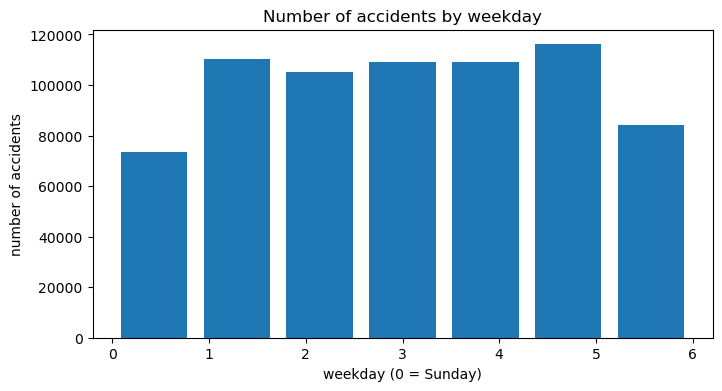

In [94]:
# during the weekend, i.e. saturday (6) and sunday (0), less accidents. 
plt.hist(accidents_df['weekday'], bins=7, rwidth=0.8)
plt.title("Number of accidents by weekday")
plt.xlabel("weekday (0 = Sunday)")
plt.ylabel("number of accidents")

In [95]:
# count number of accidents for each day/month/year
daily_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.date)['date'].count())
monthly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count())
yearly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('Y'))['date'].count())

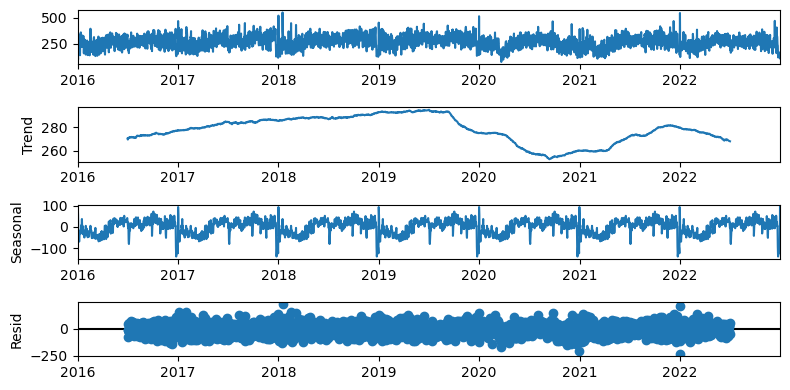

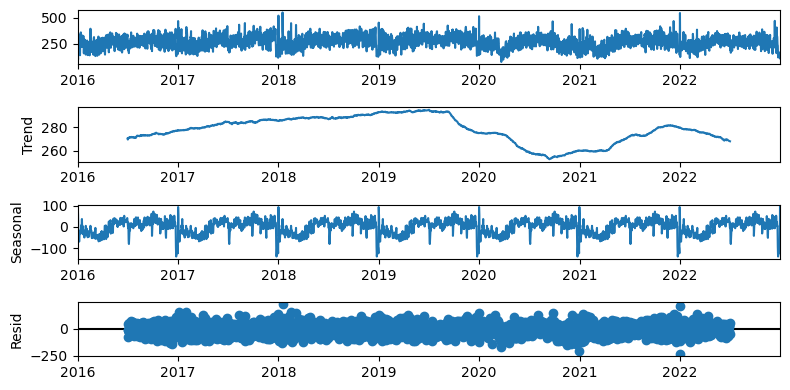

In [96]:
# seasonal decomposition
seasonal_decompose(daily_count, period=365).plot()

Text(0, 0.5, 'number of accidents')

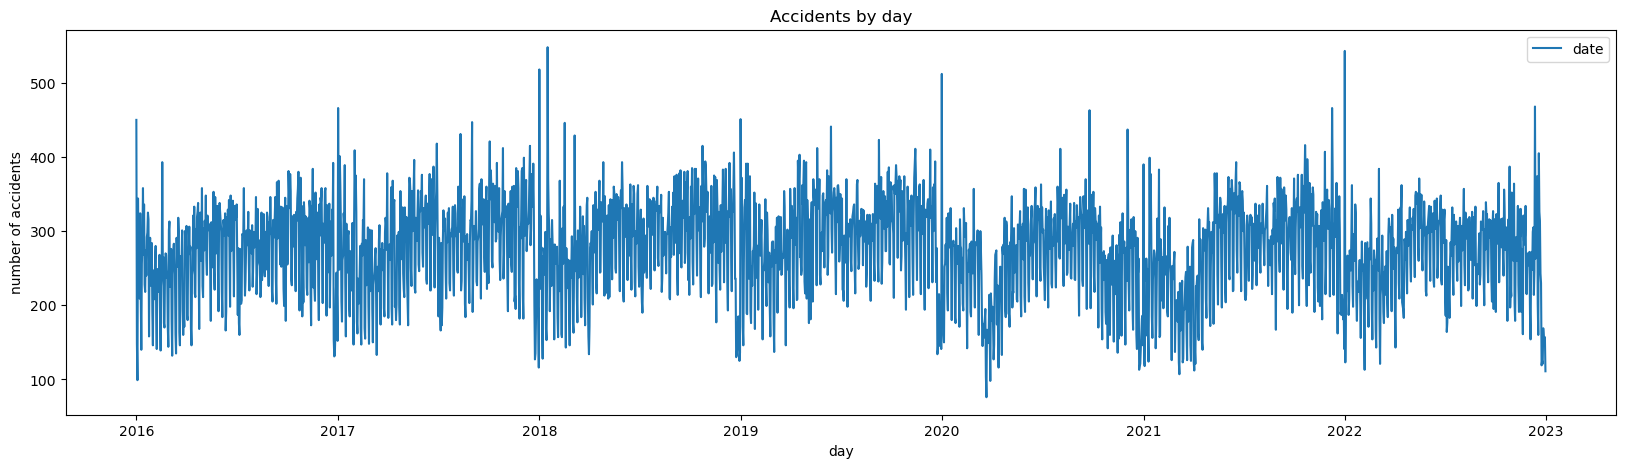

In [97]:
# plot number of accidents on each day
plt.rcParams['figure.figsize'] = [20, 5]
daily_count.plot()
plt.title("Accidents by day")
plt.xlabel("day")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

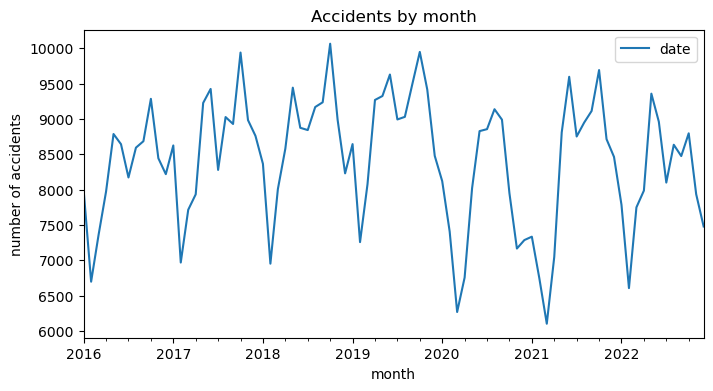

In [98]:
# plot number of accidents in each month
plt.rcParams['figure.figsize'] = [8, 4]
monthly_count.plot()
plt.title("Accidents by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

Text(0, 0.5, 'number of accidents')

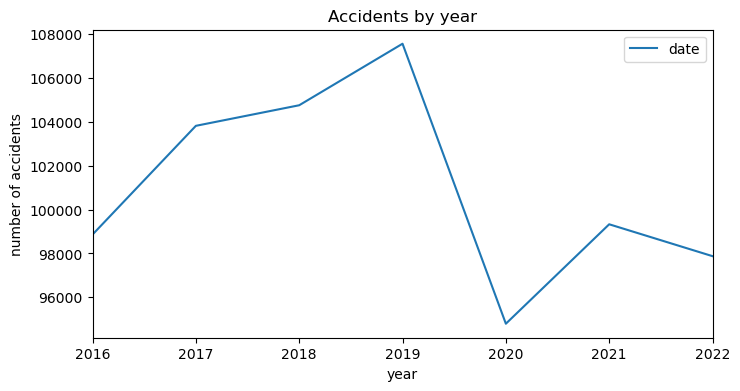

In [99]:
# plot number of accidents in each year
yearly_count.plot()
plt.title("Accidents by year")
plt.xlabel("year")
plt.ylabel("number of accidents")

In [100]:
# split the data to training set and test set
# train set = years 2016-2021, test set = year 2022
monthly_count_train = monthly_count[:len(monthly_count)-12]
monthly_count_test = monthly_count[len(monthly_count)-12:]

print(monthly_count_train)
print(monthly_count_test)

         date
date         
2016-01  7992
2016-02  6698
2016-03  7362
2016-04  7974
2016-05  8788
...       ...
2021-08  8949
2021-09  9114
2021-10  9693
2021-11  8715
2021-12  8464

[72 rows x 1 columns]
         date
date         
2022-01  7786
2022-02  6607
2022-03  7750
2022-04  7987
2022-05  9359
2022-06  8962
2022-07  8101
2022-08  8636
2022-09  8476
2022-10  8798
2022-11  7936
2022-12  7479


In [101]:
# seasonal arima with automatic parameter calculation
# seasonality period = 12 months (one year)
auto_arima = pm.auto_arima(monthly_count_train, seasonal=True, m=12)
auto_arima

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

Text(0, 0.5, 'number of accidents')

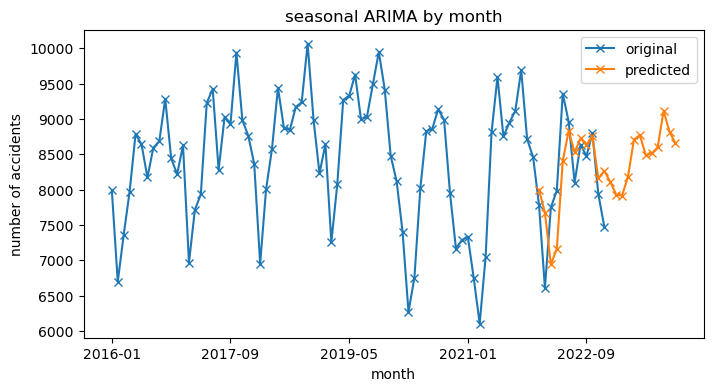

In [103]:
# SARIMA
forecast_test_auto = auto_arima.predict(n_periods=len(monthly_count_test)+12)  # predict one year from the test set and 12 months in the future
predict_df = pd.DataFrame(monthly_count)

# add future dates to predict_df
last_date = predict_df.index.max()
future_dates = pd.date_range(start=last_date.to_timestamp(), periods=13, freq='M')
new_rows = pd.DataFrame(index=future_dates, columns=predict_df.columns)
new_rows = new_rows.iloc[1:]
predict_df = pd.concat([predict_df, new_rows])

predict_df['forecast_value'] = [None]*len(monthly_count_train) + list(forecast_test_auto)

predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("seasonal ARIMA by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [104]:
# prepare data for Prophet
# Prophet needs a dataframe with 2 columns: ds (date) and y (number of accidents)
daily_count = accidents_df.groupby(accidents_df['date'].dt.date)['date'].count().to_frame()
daily_count.columns = ['y']
daily_count = daily_count.reset_index()
daily_count.columns = ['ds', 'y']

monthly_count = accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count().to_frame()
monthly_count.columns = ['y']
monthly_count = monthly_count.reset_index()
monthly_count.columns = ['ds', 'y']
monthly_count['ds'] = monthly_count['ds'].dt.to_timestamp()

yearly_count = accidents_df.groupby(accidents_df['date'].dt.to_period('Y'))['date'].count().to_frame()

# split the prepared data to training and test set
daily_count_train = daily_count[:len(daily_count)-365]
daily_count_test = daily_count[len(daily_count)-365:]

monthly_count_train = monthly_count[:len(monthly_count)-12]
monthly_count_test = monthly_count[len(monthly_count)-12:]

print(daily_count)

              ds    y
0     2016-01-01  450
1     2016-01-02  148
2     2016-01-03   99
3     2016-01-04  344
4     2016-01-05  271
...          ...  ...
2552  2022-12-27  169
2553  2022-12-28  157
2554  2022-12-29  151
2555  2022-12-30  157
2556  2022-12-31  111

[2557 rows x 2 columns]


In [105]:
# Prophet - daily

m = Prophet()
m.fit(daily_count_train)
future = m.make_future_dataframe(periods=365+366)

09:14:15 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
forecast = m.predict(future)

Text(83.09722222222221, 0.5, 'number of accidents')

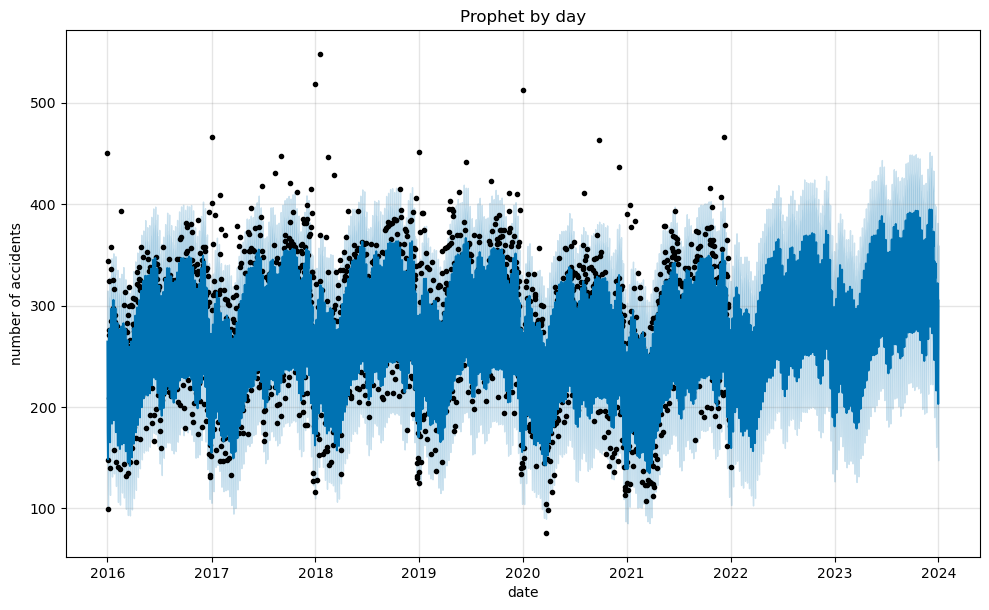

In [107]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)

fig1 = m.plot(forecast)
plt.title("Prophet by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

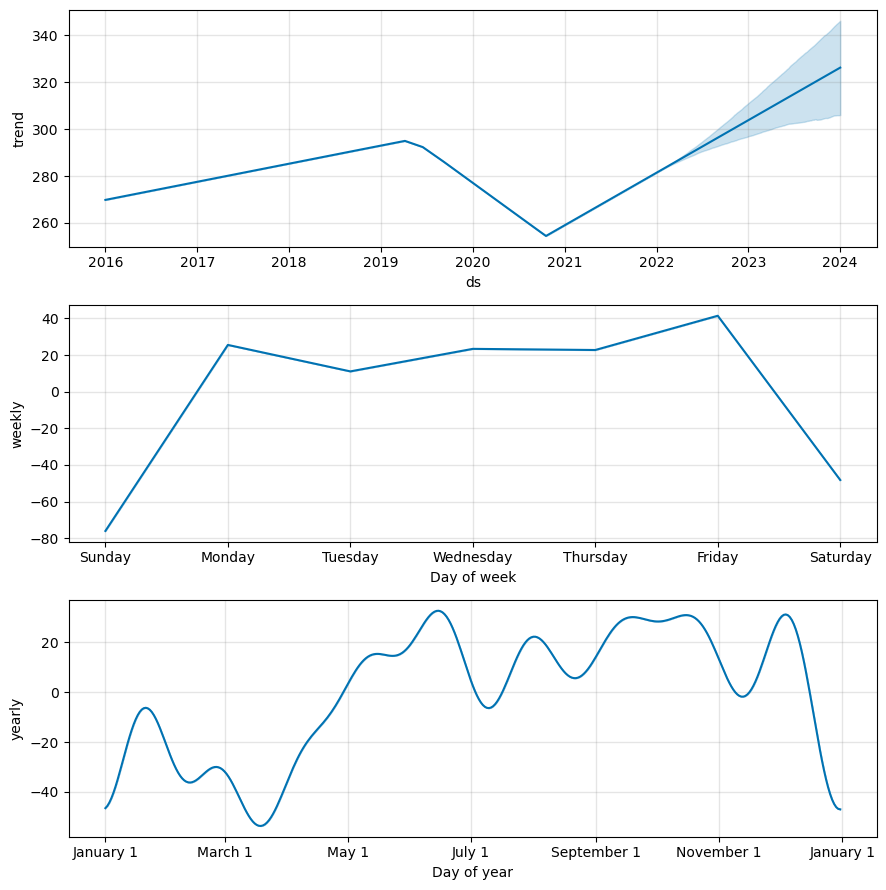

In [108]:
fig2 = m.plot_components(forecast)


C:\Users\katka\AppData\Local\Temp\ipykernel_9584\1355329270.py:16: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  predict_df.plot(marker='x')


Text(0, 0.5, 'number of accidents')

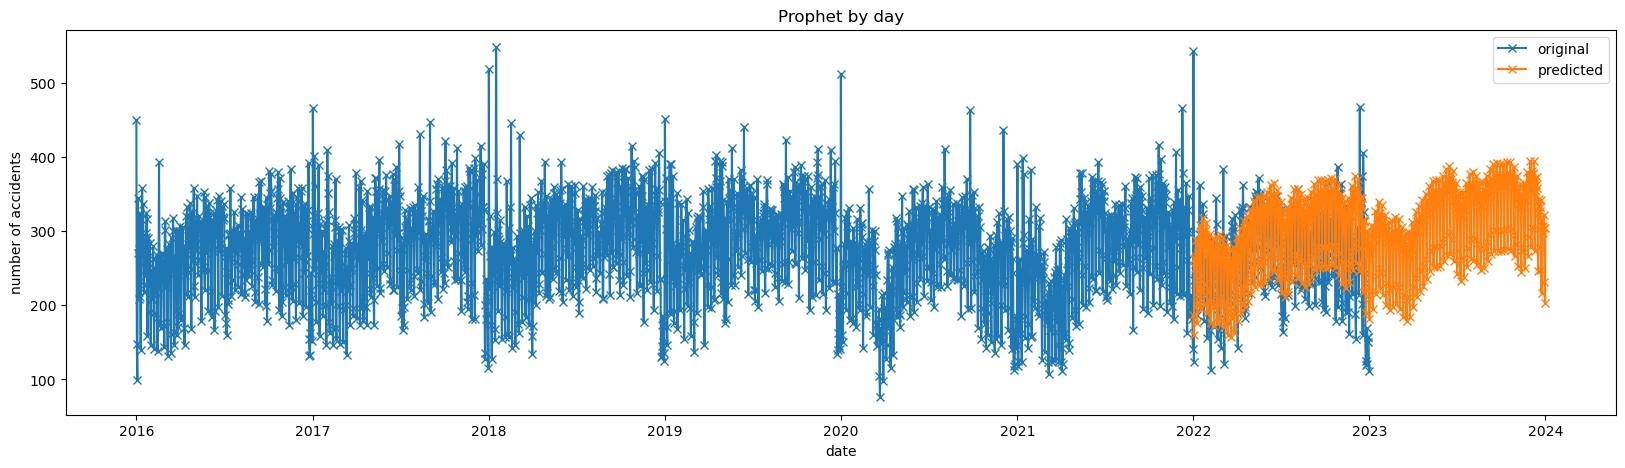

In [112]:
# plot the whole dataset + add predicted values for 2022
daily_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.date)['date'].count())
predict_df = pd.DataFrame(daily_count)

# add future dates to predict_df
last_date = predict_df.index.max()
future_dates = pd.date_range(start=last_date, periods=367, freq='d')
new_rows = pd.DataFrame(index=future_dates, columns=predict_df.columns)
new_rows = new_rows.iloc[1:]
predict_df = pd.concat([predict_df, new_rows])

predict_df['forecast_value'] = [None]*len(daily_count_train) + list(forecast['yhat'].tail(365+366))

plt.rcParams['figure.figsize'] = [20, 5]
predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("Prophet by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [115]:
# Prophet - monthly

m = Prophet()
m.fit(monthly_count_train)
future = m.make_future_dataframe(periods=24, freq='MS')
forecast = m.predict(future)

09:17:26 - cmdstanpy - INFO - Chain [1] start processing
09:17:27 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Prophet by month')

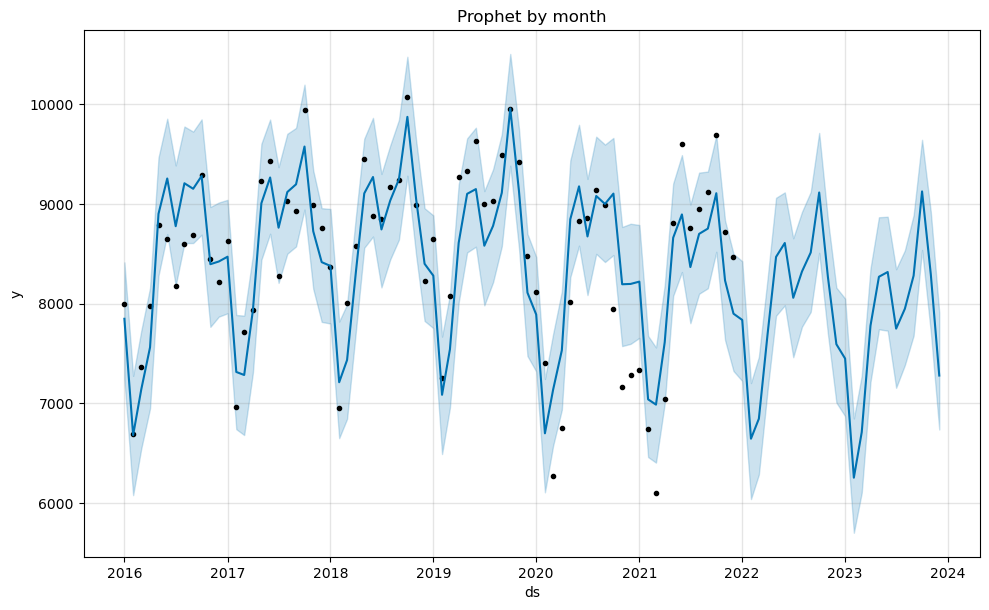

In [116]:
fig1 = m.plot(forecast)
plt.title("Prophet by month")

Text(0, 0.5, 'number of accidents')

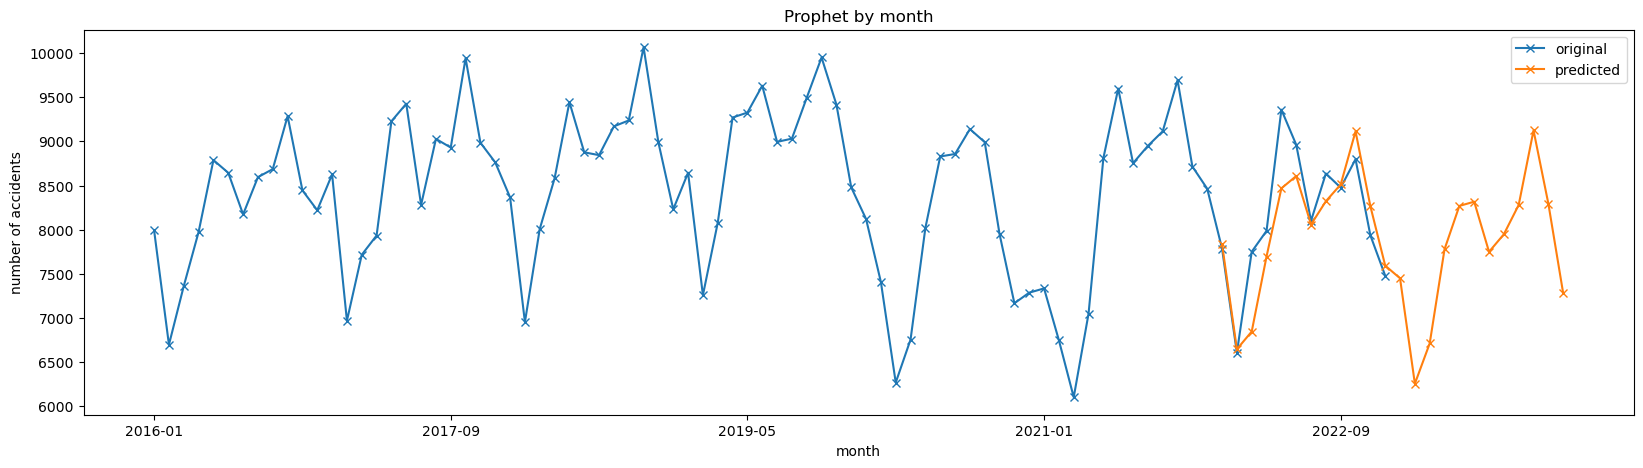

In [119]:
# plot the whole dataset + add predicted values for 2022
monthly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count())
predict_df = pd.DataFrame(monthly_count)

# add future dates to predict_df
last_date = predict_df.index.max()
future_dates = pd.date_range(start=last_date.to_timestamp(), periods=13, freq='M')
new_rows = pd.DataFrame(index=future_dates, columns=predict_df.columns)
new_rows = new_rows.iloc[1:]
predict_df = pd.concat([predict_df, new_rows])

predict_df['forecast_value'] = [None]*len(monthly_count_train) + list(forecast['yhat'].tail(24))

predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("Prophet by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [22]:
# prepare dataset for SVR
daily_count = accidents_df.groupby(accidents_df['date'].dt.date)['date'].count().to_frame()
daily_count.columns = ['y']
daily_count.index = pd.to_datetime(daily_count.index)

monthly_count = accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count().to_frame()
monthly_count.columns = ['y']
monthly_count = monthly_count.reset_index()
monthly_count.columns = ['ds', 'y']
monthly_count['ds'] = monthly_count['ds'].dt.to_timestamp()
monthly_count = monthly_count.set_index('ds')

yearly_count = accidents_df.groupby(accidents_df['date'].dt.to_period('Y'))['date'].count().to_frame()

# split data to training set and test set
daily_count_train = daily_count[:len(daily_count)-365]
daily_count_test = daily_count[len(daily_count)-365:]

monthly_count_train = monthly_count[:len(monthly_count)-12]
monthly_count_test = monthly_count[len(monthly_count)-12:]

print(daily_count_train)

              y
date           
2016-01-01  450
2016-01-02  148
2016-01-03   99
2016-01-04  344
2016-01-05  271
...         ...
2021-12-27  214
2021-12-28  199
2021-12-29  181
2021-12-30  198
2021-12-31  141

[2192 rows x 1 columns]


In [23]:
# use grid search to find the most optimal hyperparameters for SVR model
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best score:  -0.27046021919169255


In [24]:
# SVR - monthly
model = SVR(kernel='sigmoid',gamma='scale', C=0.1, epsilon=0.01)
model.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

y_pred = model.predict(monthly_count_test.index.values.reshape(-1, 1))

y_pred

array([8665.5, 8665.5, 8665.5, 8665.5, 8665.5, 8665.5, 8665.5, 8665.5,
       8665.5, 8665.5, 8665.5, 8665.5])

Text(0, 0.5, 'number of accidents')

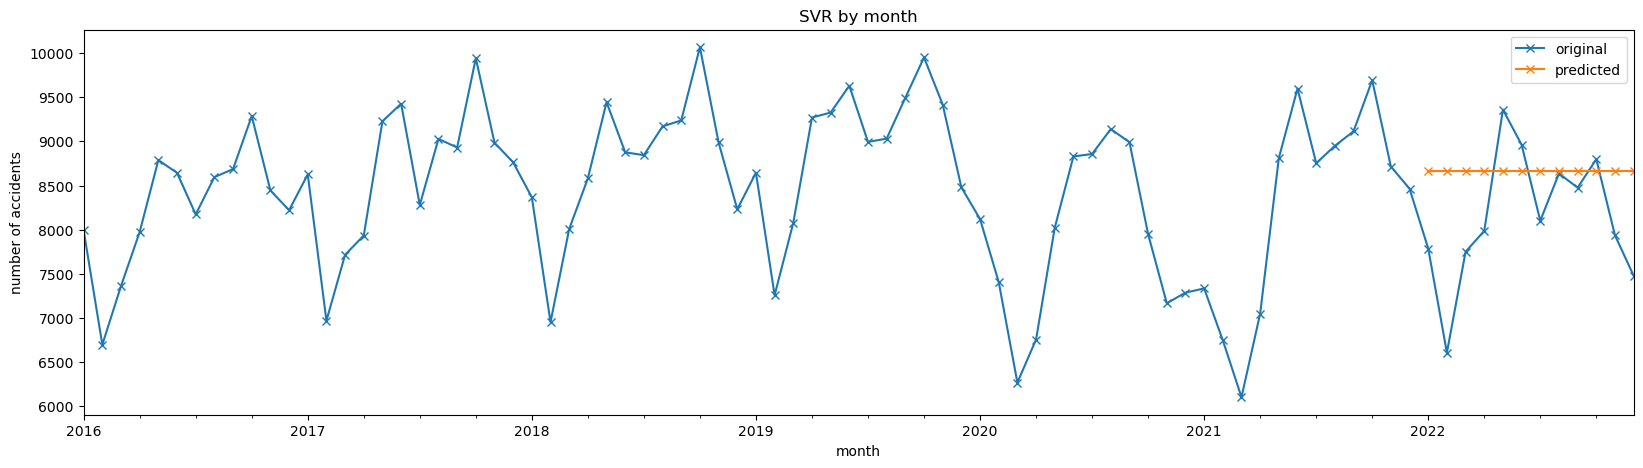

In [25]:
# plot the whole dataset + add predicted values for 2022
monthly_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count())
predict_df = pd.DataFrame(monthly_count)
predict_df['forecast_value'] = [None]*len(monthly_count_train) + list(y_pred)

predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("SVR by month")
plt.xlabel("month")
plt.ylabel("number of accidents")

In [26]:
# use grid search to find the most optimal hyperparameters for SVR model
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(daily_count_train.index.values.reshape(-1, 1), daily_count_train['y'].values)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 10, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best score:  -0.0679711556113769


In [27]:
# SVR - daily
model = SVR(kernel='rbf',gamma='auto', C=10, epsilon=1)
model.fit(daily_count_train.index.values.reshape(-1, 1), daily_count_train['y'].values)

y_pred = model.predict(daily_count_test.index.values.reshape(-1, 1))

y_pred

array([284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6, 284.6,
       284.6, 284.6,

Text(0, 0.5, 'number of accidents')

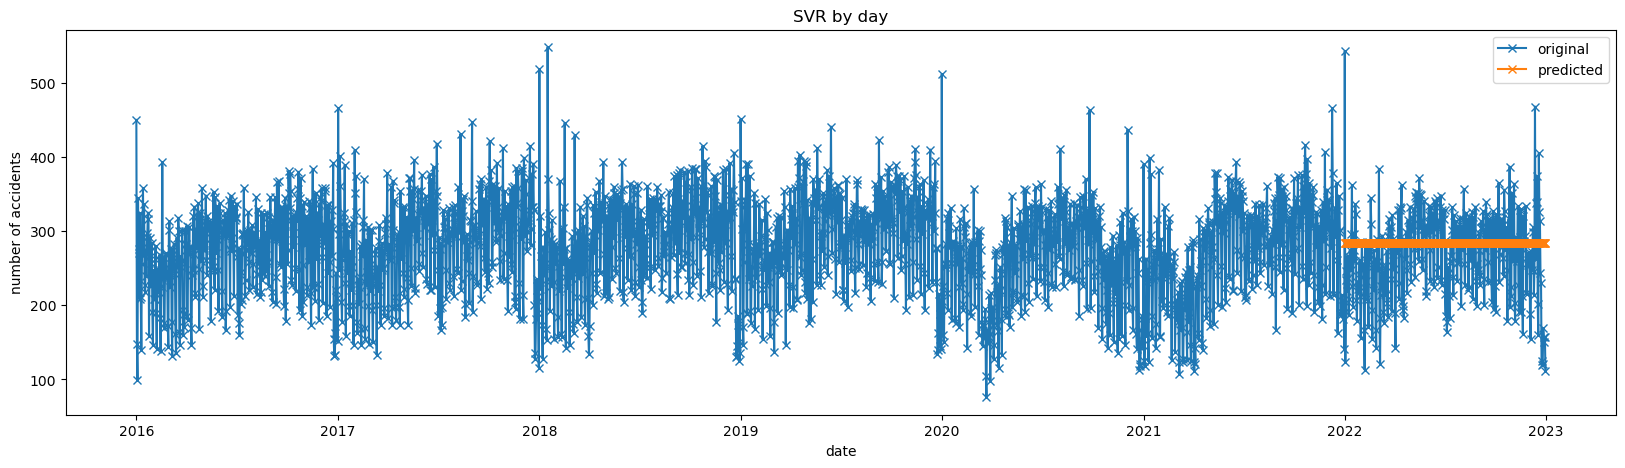

In [28]:
# plot the whole dataset + add predicted values for 2022
daily_count = pd.DataFrame(accidents_df.groupby(accidents_df['date'].dt.date)['date'].count())
predict_df = pd.DataFrame(daily_count)
predict_df['forecast_value'] = [None]*len(daily_count_train) + list(y_pred)

plt.rcParams['figure.figsize'] = [20, 5]
predict_df.columns = ["original", "predicted"]
predict_df.plot(marker='x')
plt.title("SVR by day")
plt.xlabel("date")
plt.ylabel("number of accidents")

In [29]:
# scaling the data for SVR
window_size = 3

# Compute rolling mean and standard deviation
rolling_mean = monthly_count_train['y'].rolling(window=window_size).mean()
rolling_std = monthly_count_train['y'].rolling(window=window_size).std()

# Apply scaling transformation to each time step
scaled_data = (monthly_count_train['y'] - rolling_mean) / rolling_std

scaled_data

monthly_count_train['y'] = scaled_data


In [30]:
monthly_count_train = monthly_count_train.iloc[2:]
monthly_count_train

,y
ds,
2016-03-01,0.017515
2016-04-01,0.986143
2016-05-01,1.043734
2016-06-01,0.403620
2016-07-01,-1.125402
...,...
2021-08-01,-0.341417
2021-09-01,0.970184
2021-10-01,1.128667


In [31]:
#find optimal hyperparameters susing grid search for scaled data
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto', 0.1, 1]
}

cv = TimeSeriesSplit(n_splits=5)

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=cv)
grid_search.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'C': 1, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best score:  -0.005894129697184436


In [32]:
# SVR - monhtly with scaled data
model = SVR(kernel='rbf',gamma='auto', C=1, epsilon=1)
model.fit(monthly_count_train.index.values.reshape(-1, 1), monthly_count_train['y'].values)

y_pred = model.predict(monthly_count_test.index.values.reshape(-1, 1))

y_pred

array([0.01510384, 0.01510384, 0.01510384, 0.01510384, 0.01510384,
       0.01510384, 0.01510384, 0.01510384, 0.01510384, 0.01510384,
       0.01510384, 0.01510384])

In [13]:
!pip install scalecast --upgrade

In [147]:
from scalecast.Forecaster import Forecaster

In [148]:
monthly_count = accidents_df.groupby(accidents_df['date'].dt.to_period('M'))['date'].count().to_frame()
monthly_count.columns = ['y']
monthly_count = monthly_count.reset_index()
monthly_count.columns = ['ds', 'y']
monthly_count['ds'] = monthly_count['ds'].dt.to_timestamp()
monthly_count = monthly_count.set_index('ds')
monthly_count[["y"]] = monthly_count[["y"]].values.astype('float32')

In [149]:
daily_count = accidents_df.groupby(accidents_df['date'].dt.date)['date'].count().to_frame()
daily_count.columns = ['y']
daily_count.index = pd.to_datetime(daily_count.index)
daily_count[["y"]] = daily_count[["y"]].values.astype('float32')
daily_count = daily_count.reset_index()
daily_count.columns = ['ds', 'y']

In [35]:
f_daily = Forecaster(
    y=np.array(daily_count['y']),
    current_dates=np.array(daily_count['ds'])
)
f_daily

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [36]:
f_daily.set_test_length(12)  # reserve last 12 observations (a year) as a test set
f_daily.generate_future_dates(12)  # predict 12 months into the future
f_daily.set_validation_length(f.test_length)
f_daily.auto_Xvar_select()
f_daily

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-31T00:00:00.000000000
    Freq=D
    N_actuals=2557
    ForecastLength=12
    Xvars=[]
    TestLength=12
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [38]:
for method in ['arima', 'svr', 'mlp', 'lstm']:
    f_daily.set_estimator(method)
    f_daily.tune()  # find optimal hyperparameters for selected method
    f_daily.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {method}:')
    print(f_daily.best_params)

Hyperparameter values for arima:
{'order': (2, 0, 0), 'seasonal_order': (0, 0, 2, 12)}
Hyperparameter values for svr:
{'kernel': 'poly', 'C': 2, 'epsilon': 0.5, 'gamma': 'scale'}
Hyperparameter values for mlp:
{'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'solver': 'lbfgs', 'normalizer': 'scale'}
80/80 [==============================] - 1s 7ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'dropout': (0, 0, 0), 'lags': 12, 'verbose': 0, 'epochs': 50}


<Axes: xlabel='Date', ylabel='Values'>

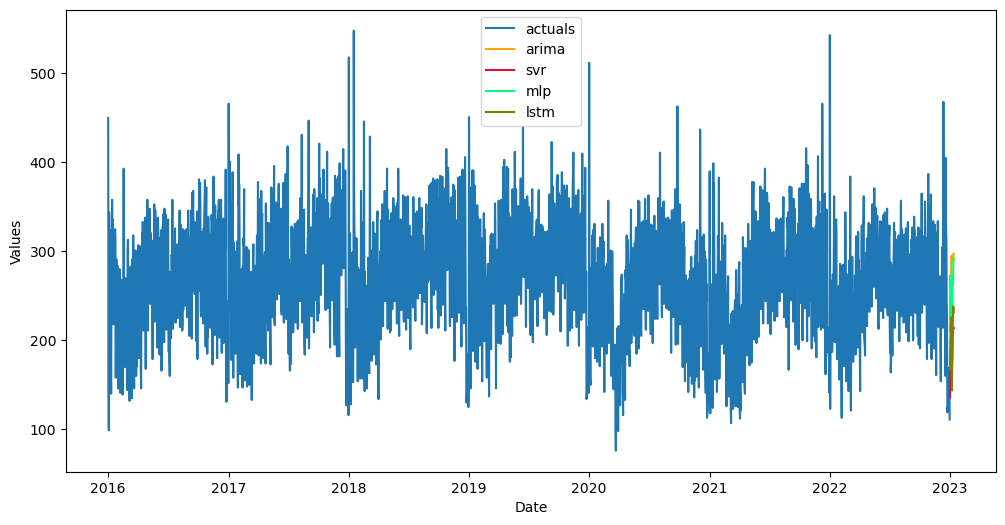

In [66]:
f_daily.plot()  # plots future values
f_daily.plot_test_set()  # plots values from test set

In [40]:
# models orderet from best performing to worst performing
f.order_fcsts()

['arima', 'lstm', 'svr', 'mlp']

In [150]:
f_monthly = Forecaster(
    y=np.array(monthly_count.reset_index()['y']),
    current_dates=np.array(monthly_count.reset_index()['ds'])
)
f_monthly

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=84
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [151]:
f_monthly.set_test_length(12)  # reserve last 12 observations (a year) as a test set
f_monthly.generate_future_dates(12)  # predict 12 months into the future
f_monthly.set_validation_length(f.test_length)
f_monthly.auto_Xvar_select()
f_monthly

Forecaster(
    DateStartActuals=2016-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=84
    ForecastLength=12
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos']
    TestLength=12
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [152]:
for method in ['svr', 'mlp', 'lstm']:
    f_monthly.set_estimator(method)
    f_monthly.tune()  # find optimal hyperparameters for selected method
    f_monthly.auto_forecast()  # predict future values using hyperparameters from the previous step
    print(f'Hyperparameter values for {method}:')
    print(f_monthly.best_params)

Hyperparameter values for svr:
{'kernel': 'poly', 'C': 3, 'epsilon': 1, 'gamma': 'scale'}
Hyperparameter values for mlp:
{'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'solver': 'lbfgs', 'normalizer': 'minmax'}
2/2 [==============================] - 0s 20ms/step
Hyperparameter values for lstm:
{'lstm_layer_sizes': (50, 50, 50), 'activation': 'relu', 'dropout': (0, 0, 0), 'lags': 10, 'verbose': 0, 'epochs': 25}


<Axes: xlabel='Date', ylabel='Values'>

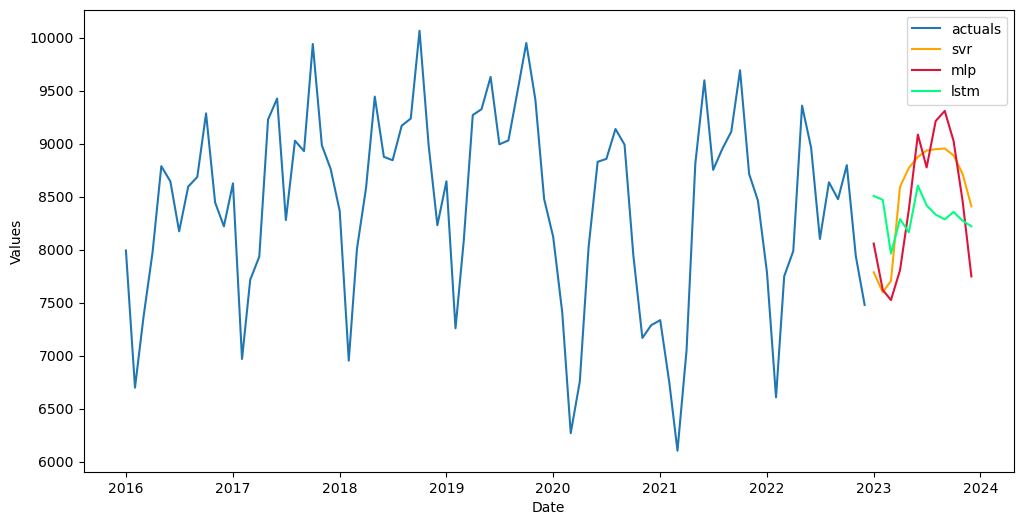

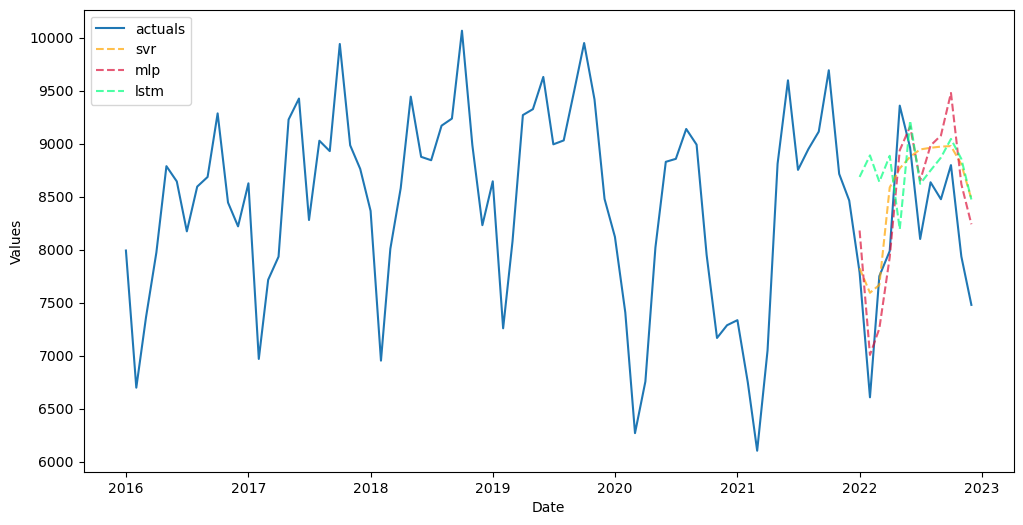

In [153]:
f_monthly.plot()  # plots future values
f_monthly.plot_test_set()  # plots values from test set